In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import keras
from scipy import ndimage
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from keras import backend as K


In [2]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Simple LeNet like in the paper without activation

In [9]:
inp = keras.Input(shape=input_shape)

x = layers.Conv2D(filters=5, kernel_size=(5,5), activation='relu')(inp)
x = layers.Conv2D(filters=5, kernel_size=(3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(units=512, activation='relu')(x)
x = layers.Dense(units=128, activation='relu')(x)
x = layers.Dense(units=10)(x)


model = keras.Model(inp, x)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 5)         130       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 5)         230       
_________________________________________________________________
flatten_1 (Flatten)          (None, 2420)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1239552   
_________________________________________________________________
dense_3 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290

Defining KL and loss function from equation 5

In [10]:
lgamma = tf.math.lgamma
digamma = tf.math.digamma

epochs = [1]

def KL(alpha, num_classes=10):
  one = K.constant(np.ones((1,num_classes)),dtype=tf.float32)
  S = K.sum(alpha,axis=1,keepdims=True)  

  kl = lgamma(S) - K.sum(lgamma(alpha),axis=1,keepdims=True) +\
      K.sum(lgamma(one),axis=1,keepdims=True) - lgamma(K.sum(one,axis=1,keepdims=True)) +\
      K.sum((alpha - one)*(digamma(alpha)-digamma(S)),axis=1,keepdims=True)
          
  return kl


def loss_func(y_true, output):
    y_evidence = K.relu(output)
    alpha = y_evidence+1
    S = K.sum(alpha,axis=1,keepdims=True)
    p = alpha / S  

    err = K.sum(K.pow((y_true-p),2),axis=1,keepdims=True)
    var = K.sum(alpha*(S-alpha)/(S*S*(S+1)),axis=1,keepdims=True)
    
    l =  K.sum(err + var,axis=1,keepdims=True)
    l = K.sum(l)
    
    
    kl =  K.minimum(1.0, epochs[0]/50) * K.sum(KL((1-y_true)*(alpha)+y_true))
    return l + kl




In [11]:
batch_size = 1024
model.compile(loss=loss_func, optimizer="adam", metrics=['accuracy'])
for i in range(30):
  print(i+1)
  model.fit(x_train, y_train, batch_size=batch_size, epochs=1, validation_split=0.1)
  epochs[0]+=1


1
53/53 [==============================] - 2s 17ms/step - loss: 656.5315 - accuracy: 0.6787 - val_loss: 169.4785 - val_accuracy: 0.9380
2
53/53 [==============================] - 1s 14ms/step - loss: 171.1368 - accuracy: 0.9276 - val_loss: 112.2213 - val_accuracy: 0.9580
3
53/53 [==============================] - 1s 12ms/step - loss: 125.0644 - accuracy: 0.9477 - val_loss: 85.9031 - val_accuracy: 0.9683
4
53/53 [==============================] - 1s 11ms/step - loss: 97.9829 - accuracy: 0.9597 - val_loss: 73.8297 - val_accuracy: 0.9735
5
53/53 [==============================] - 1s 11ms/step - loss: 82.5725 - accuracy: 0.9657 - val_loss: 62.3483 - val_accuracy: 0.9745
6
53/53 [==============================] - 1s 12ms/step - loss: 71.1813 - accuracy: 0.9700 - val_loss: 55.0914 - val_accuracy: 0.9787
7
53/53 [==============================] - 1s 11ms/step - loss: 61.0695 - accuracy: 0.9757 - val_loss: 50.9739 - val_accuracy: 0.9790
8
53/53 [==============================] - 1s 12ms/step -

In [12]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.0993051528930664
Test accuracy: 0.9846000075340271


calculating probability and uncertinty

In [13]:
def rotate(im,deg):
  #rotation angle in degree
  return ndimage.rotate(im, deg)

def calc_prob_uncertinty(p):
  
  evidence = np.maximum(p[0], 0)

  alpha = evidence +1

  u = 10/ alpha.sum()
  prob = alpha[np.argmax(alpha)] / alpha.sum()
  return prob, u



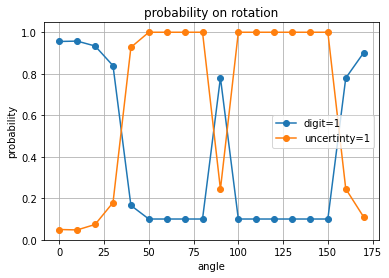

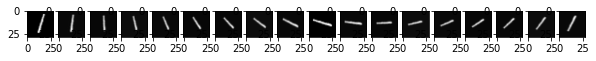

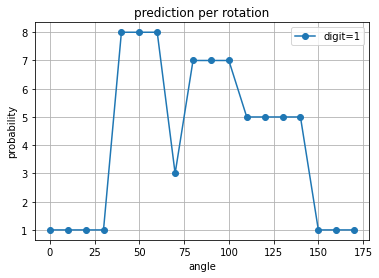

In [26]:
digit = 1
angles_range = list(range(0,180,10))

test_labels = np.argmax(y_test,axis=1)

predictions = []
uncertinties = []
probabilities= []
imgs = []
for angle in angles_range:    

  im = x_test[np.where(test_labels==digit)[0][0]]    
  shape = im.shape
  im = rotate(im, angle)    
  im = cv2.resize(im,shape[:-1],interpolation = cv2.INTER_AREA)
  imgs.append(im)
  p = model.predict(np.array([im.reshape(shape)]))  
  prob, uncertinty = calc_prob_uncertinty(p)
  uncertinties.append(uncertinty)
  probabilities.append(prob)  
  predictions.append(np.argmax(p))

plt.plot(angles_range,probabilities, label=f'digit={d}',marker='o')
plt.plot(angles_range,uncertinties, label=f'uncertinty={d}',marker='o')

plt.xlabel('angle')
plt.ylabel('probability')
plt.legend()
plt.title('probability on rotation')
plt.grid()
plt.show()
f,axs = plt.subplots(1,len(imgs),figsize=(10,20))
for ax,im in zip(axs.ravel(),imgs):
  ax.imshow(im,cmap='gray')
plt.show()

plt.plot(angles_range,predictions, label=f'digit={d}',marker='o')
plt.xlabel('angle')
plt.ylabel('probability')
plt.legend()
plt.title('prediction per rotation')
plt.grid()
plt.show()